<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#LyricsManager.py" data-toc-modified-id="LyricsManager.py-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LyricsManager.py</a></span></li><li><span><a href="#MoodyLyrics-issue" data-toc-modified-id="MoodyLyrics-issue-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>MoodyLyrics issue</a></span></li><li><span><a href="#New-features" data-toc-modified-id="New-features-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>New features</a></span><ul class="toc-item"><li><span><a href="#Dataset-Stats" data-toc-modified-id="Dataset-Stats-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Dataset Stats</a></span></li><li><span><a href="#Feature-Analysis" data-toc-modified-id="Feature-Analysis-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Feature Analysis</a></span></li><li><span><a href="#Feature-Selection" data-toc-modified-id="Feature-Selection-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Feature Selection</a></span><ul class="toc-item"><li><span><a href="#Extra-test-set" data-toc-modified-id="Extra-test-set-4.3.1"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>Extra test set</a></span></li></ul></li></ul></li><li><span><a href="#Classification" data-toc-modified-id="Classification-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Classification</a></span><ul class="toc-item"><li><span><a href="#Artificial-Neural-Network" data-toc-modified-id="Artificial-Neural-Network-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Artificial Neural Network</a></span><ul class="toc-item"><li><span><a href="#Cross-Validation" data-toc-modified-id="Cross-Validation-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Cross Validation</a></span></li><li><span><a href="#Analysis-on-Extra-Test" data-toc-modified-id="Analysis-on-Extra-Test-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>Analysis on Extra Test</a></span></li><li><span><a href="#Playlist-Classification" data-toc-modified-id="Playlist-Classification-5.1.3"><span class="toc-item-num">5.1.3&nbsp;&nbsp;</span>Playlist Classification</a></span></li></ul></li><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Logistic Regression</a></span><ul class="toc-item"><li><span><a href="#Playlist-Classification" data-toc-modified-id="Playlist-Classification-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Playlist Classification</a></span></li></ul></li><li><span><a href="#SVM" data-toc-modified-id="SVM-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>SVM</a></span></li><li><span><a href="#eXtreme-Gradient-Boost" data-toc-modified-id="eXtreme-Gradient-Boost-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>eXtreme Gradient Boost</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

In [1]:
import spacy
import os
import sys
import warnings
import itertools

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.decomposition import PCA

import seaborn as sns
sns.set_style("whitegrid")
sns.set_color_codes()
import matplotlib.pyplot as plt

from utils.datasets import load_dataset_from_path, split_train_validation

emotion_labels = ['happy', 'sad', 'angry', 'relaxed']

In [2]:
# Read extra test set
extra_test_path = './datasets/extra_test.csv'
extra_test = pd.read_csv(extra_test_path)

In [3]:
def plot_confusion_matrix(cm, classes = emotion_labels,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
def plot_pca_exp_var(x, dim):
    '''
    Utility function used to plot the explained variance
    variation by doing dimensionality reduction
    '''
    # Perform PCA and get explained variance
    pca = PCA(n_components=dim)
    x_pca = pca.fit_transform(x)
    exvar = (pca.explained_variance_ratio_)
    exvar.sort()
    exvar = exvar[::-1]
    
    # Compute CDF
    cdf = np.zeros_like(exvar)
    for i in range(len(exvar)):
        cdf[i] = exvar[0] if i == 0 else cdf[i-1]+exvar[i]
    cdf = np.insert(cdf, 0, 0)
    
    # Plot
    ax = plt.gca()

    # Find point in which we have 75% information
    #f = np.where(cdf >= 0.75)[0][0]
    #ax.axhline(0.75, color='orange', linestyle='-.',lw=2, alpha=0.5)
    #ax.axvline(f, linestyle='-.', color='orange', lw=2, alpha=0.5)
    #ax.text(f+5, 0.1, '%s features' % f)

    # Find point in which we have 99% information
    f = np.where(cdf >= 0.99)[0][0]
    ax.axhline(0.99, color='green', linestyle='-.',lw=2, alpha=0.5)
    ax.axvline(f, linestyle='-.', color='green', lw=2, alpha=0.5)
    ax.text(f+5, 0.1, '%s features' % f)

    plt.title('Explained Variance')
    plt.xlabel('Number of Components')
    plt.plot(np.arange(dim + 1), cdf, lw=2.5)
    plt.show()

# Introduction
**Previously on Sara&Mario project**: 
<ol>
    <li>*MoodyLyrics* stats analysis</li>
    <li>Lyrics classification using the main classifiers</li>
    <li>Emotion classification by just considering the song title</li> 
</ol>
Now, following the last meeting discussion we: 
<ol>
    <li>Wrote a script to create the dataset *SpotifyURI*, *List of PlaylistIDs*, *MoodyLyric_Emotion*</li>
    <li>Wrote a script to detect all duplicated songs in MoodyLyrics to fill a bug report</li>
    <li>Added new features for the classification task</li>
</ol>

# LyricsManager.py
After downloading the Spotify RecSys Challenge dataset we wrote a script that: <br>
<ul>
    <li>Given as input: the *Spotify playlist dataset folder*, and an output folder, creates a data structure to store for each song:<br>
        <*SpotifyURI*, *PlaylistIDs*, *TrackInformation*, *Emotion*><br>
        where: 
            <ul>
                <li>*SpotifyURI* is the songID</li>
                <li>*PlaylistsIDs* is the list of playlist in which the song appear</li>
                <li>*TrackInformation* is the list of information taken from Spotify dataset</li>
                <li>*Emotion* is an optional field, present only if the song is also contained in the MoodyLyrics dataset, that contains the emotion label for the song
    </li>
            </ul>
      <li>Can load Spotify songs datastructure (if already existing)</li>
            <li>Given as input a SpotifyURI it can download lyrics from lyricwikia</li>
</ul>

# MoodyLyrics issue
New week we detected duplicate information in MoodyLyrics. Now we can generate a .csv file capable of reporting those duplicates.

Now it's time to fill a bug.

# New features
Starting from MoodyLyrics we are going to create a new dataset with a lot of new features. <br>
<ul>
    <li>**Title_vector**</li>
    <li>**Lyric_vector**</li>
    <li>**%Rhymes**:<br> defined as the percentage of the number of rhymes over the number of total lines. A rhyme is defined as a rhyme between two following lines.</li>
    <li>**%Past_tense_verbs**:<br> defined as the the percentage of the number of past tense verbs over the total number of verbs.</li>
    <li>**%Present_tense_verbs**:<br>  defined as the the percentage of the number of present tense verbs over the total number of verbs.</li>
    <li>**%Future_tense_verbs**:<br>  defined as the the percentage of the number of future tense verbs over the total number of verbs, where future is just will + base form.</li>
    <li>**%ADJ**:<br> Percentage of adjectives over the total number of words.</li>
    <li>**%ADP**:<br> Percentage of adpositions (e.g. in, to, during) over the total number of words.</li>
    <li>**%ADV**:<br> Percentage of adverbs (e.g. very, tomorrow, down, where, there) over the total number of words.</li>
    <li>**%AUX**:<br> Percentage of auxiliaries (e.g. is, has (done), will (do), should (do)) over the total number of words.</li>
    <li>**%INTJ**:<br> Percentage of interjections (e.g. psst, ouch, bravo, hello) over the total number of words.</li>
    <li>**%NOUN**:<br> Percentage of nouns over the total number of words.</li>
    <li>**%NUM**:<br> Percentage of numerals over the total number of words.</li>
    <li>**%PRON**:<br> Percentage of pronouns (e.g. I, you, he, she, myself, themselves, somebody,...) over the total number of words.</li> 
    <li>**%PROPN**:<br> Percentage of proper nouns (e.g. Mary, John) over the total number of words.</li>
    <li>**%PUNCT**:<br> Percentage of puntuctuation (e.g. ., (, ), ?) over the total number of words.</li>
    <li>**%VERB**:<br> Percentage of verbs over the total number of words.</li>
    <li>**Selfish_degree**:<br> Percentage of 'I' pronouns over the total number of pronouns</li>
    <li>**%Echoism**:<br> Percentage of echoism over the total number of words, where an echoism is either a sequence of two subsequent repeated words or the repetition of a vowel in a word. </li>
    <li>**%Duplicates**:<br> Percentage of duplicate words over the total number of words</li>
    <li>**isTitleInLyric**:<br> Boolean, true if the title string is also a substring of the lyric</li>
    <li>**sentiment**:<br> Sentiment between -1 and 1</li>
    <li>**subjectivity degree**:<br> Degree of subjectivity of the text</li>
</ul>

The sentiment and subjectivity analysis was done using [TextBlob](http://textblob.readthedocs.io/en/dev/index.html) Python NLP library.

## Dataset Stats

In [5]:
moodyLyrics4qDF = pd.read_csv('./datasets/MoodyLyrics4Q.csv')
moodyLyricsDF   = pd.read_csv('./datasets/moodylyrics_cleaned.csv')

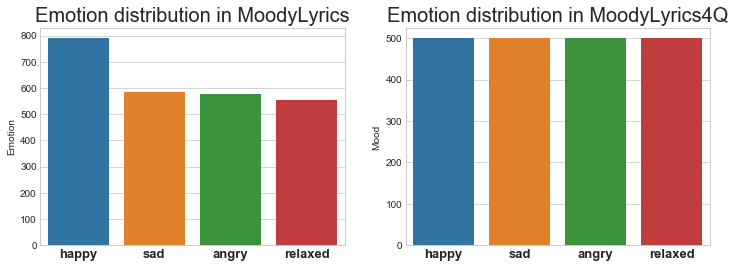

2000
2509
(2000, 3)
(0, 3)


In [6]:
f, axarr = plt.subplots(1, 2, figsize=(12,4))
emotionDistribution = moodyLyricsDF.Emotion.value_counts()
ax = sns.barplot(x=np.array(range(4)),y=emotionDistribution, ax = axarr[0])
ax.set_title('Emotion distribution in MoodyLyrics',fontsize=20)
ax.set_xticklabels(emotion_labels,fontsize=13, fontweight='bold')

emotionDistribution = moodyLyrics4qDF.Mood.value_counts()
ax = sns.barplot(x=np.array(range(4)),y=emotionDistribution, ax = axarr[1])
ax.set_title('Emotion distribution in MoodyLyrics4Q',fontsize=20)
ax.set_xticklabels(emotion_labels,fontsize=13, fontweight='bold')
plt.savefig('Stats.png')
plt.show()

## Compare size
print(len(moodyLyrics4qDF))
print(len(moodyLyricsDF))

## Check if MoodyLyrics4q has duplicates as well
duplicatedCheck = moodyLyrics4qDF.groupby(['Artist','Title']).size().reset_index(name='count')
print(duplicatedCheck.shape)
duplicatedRows = duplicatedCheck [(duplicatedCheck ['count']>1)]
print(duplicatedRows.shape)

## Feature Analysis

In [7]:
use_both = True
moodyLyrics4q_F = pd.read_csv('./datasets/moodylyrics4q_featurized.csv')
if use_both:
    moodyLyrics_F = pd.read_csv('./datasets/moodylyrics_featurized.csv')
    total_len = len(moodyLyrics4q_F ) + len(moodyLyrics_F )
    dataset = pd.concat([moodyLyrics4q_F , moodyLyrics_F])
    dataset.drop_duplicates(['ARTIST', 'SONG_TITLE'], inplace=True)
    print('Deleted duplicated songs: ',total_len - len(dataset))
else: 
    dataset = moodyLyrics4q_F

Deleted duplicated songs:  46


In [8]:
print(dataset.columns)

Index(['Unnamed: 0', 'ID', 'ARTIST', 'SONG_TITLE', 'LYRICS_VECTOR',
       'TITLE_VECTOR', 'LINE_COUNT', 'WORD_COUNT', 'ECHOISMS',
       'SELFISH_DEGREE', 'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'RHYMES',
       'VERB_PRESENT', 'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES',
       'CONJUCTION_FREQUENCIES', 'ADV_FREQUENCIES', 'AUX_FREQUENCIES',
       'CONJ_FREQUENCIES', 'CCONJ_FREQUENCIES', 'DETERMINER_FREQUENCIES',
       'INTERJECTION_FREQUENCIES', 'NOUN_FREQUENCIES', 'NUM_FREQUENCIES',
       'PART_FREQUENCIES', 'PRON_FREQUENCIES', 'PROPN_FREQUENCIES',
       'PUNCT_FREQUENCIES', 'SCONJ_FREQUENCIES', 'SYM_FREQUENCIES',
       'VERB_FREQUENCIES', 'X_FREQUENCIES', 'SPACE_FREQUENCIES', 'SENTIMENT',
       'SUBJECTIVITY', 'EMOTION'],
      dtype='object')


In [9]:
print(dataset.shape)

(4378, 38)


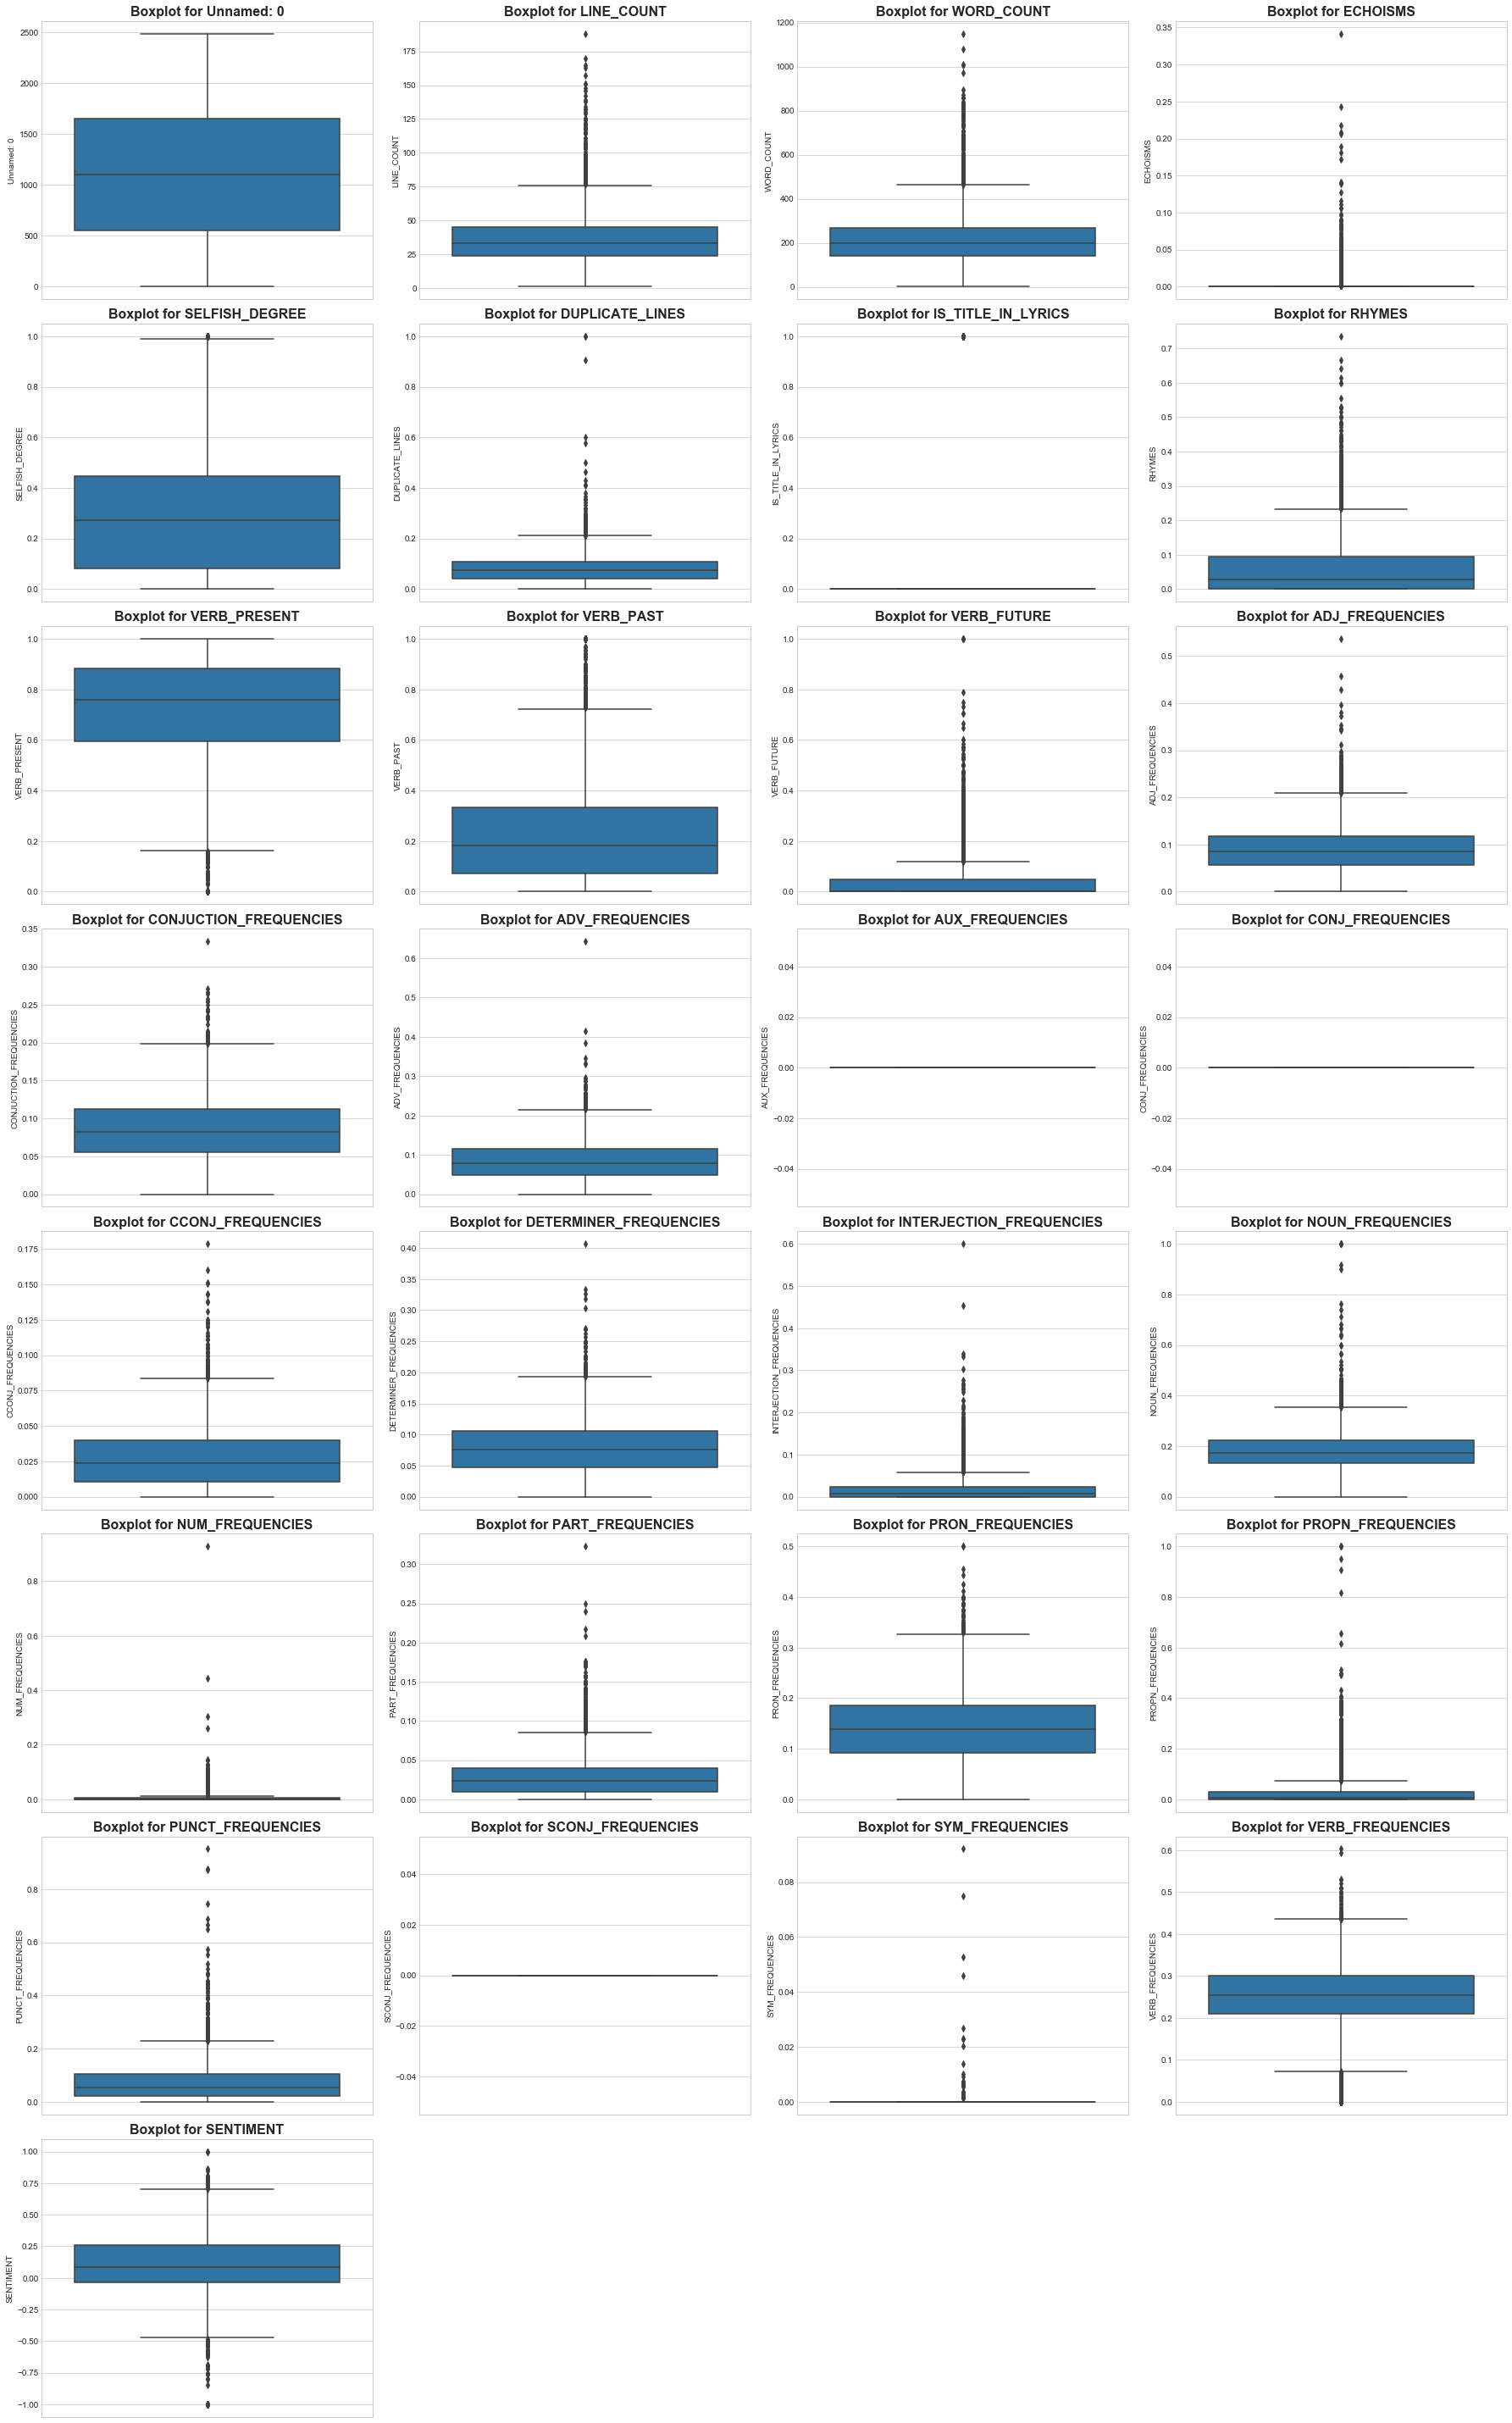

In [10]:
useless_columns = [ 'ID','ARTIST', 'SONG_TITLE', 'EMOTION', 'X_FREQUENCIES', 'SPACE_FREQUENCIES']
tmp_df = dataset.drop(useless_columns + ['LYRICS_VECTOR', 'TITLE_VECTOR'],axis=1)

f, axarr = plt.subplots(8, 4, figsize=(25,40))
k = 0
for feature in tmp_df.columns:
    (i, j) = divmod(k, 4)
    axarr[i,j] = sns.boxplot(y=tmp_df[feature], ax=axarr[i,j])
    axarr[i,j].set_title('Boxplot for {}'.format(feature), fontsize=16, weight='bold')
    k += 1
plt.tight_layout()
f.delaxes(axarr[-1,-1])
f.delaxes(axarr[-1,-2])
f.delaxes(axarr[-1,-3])

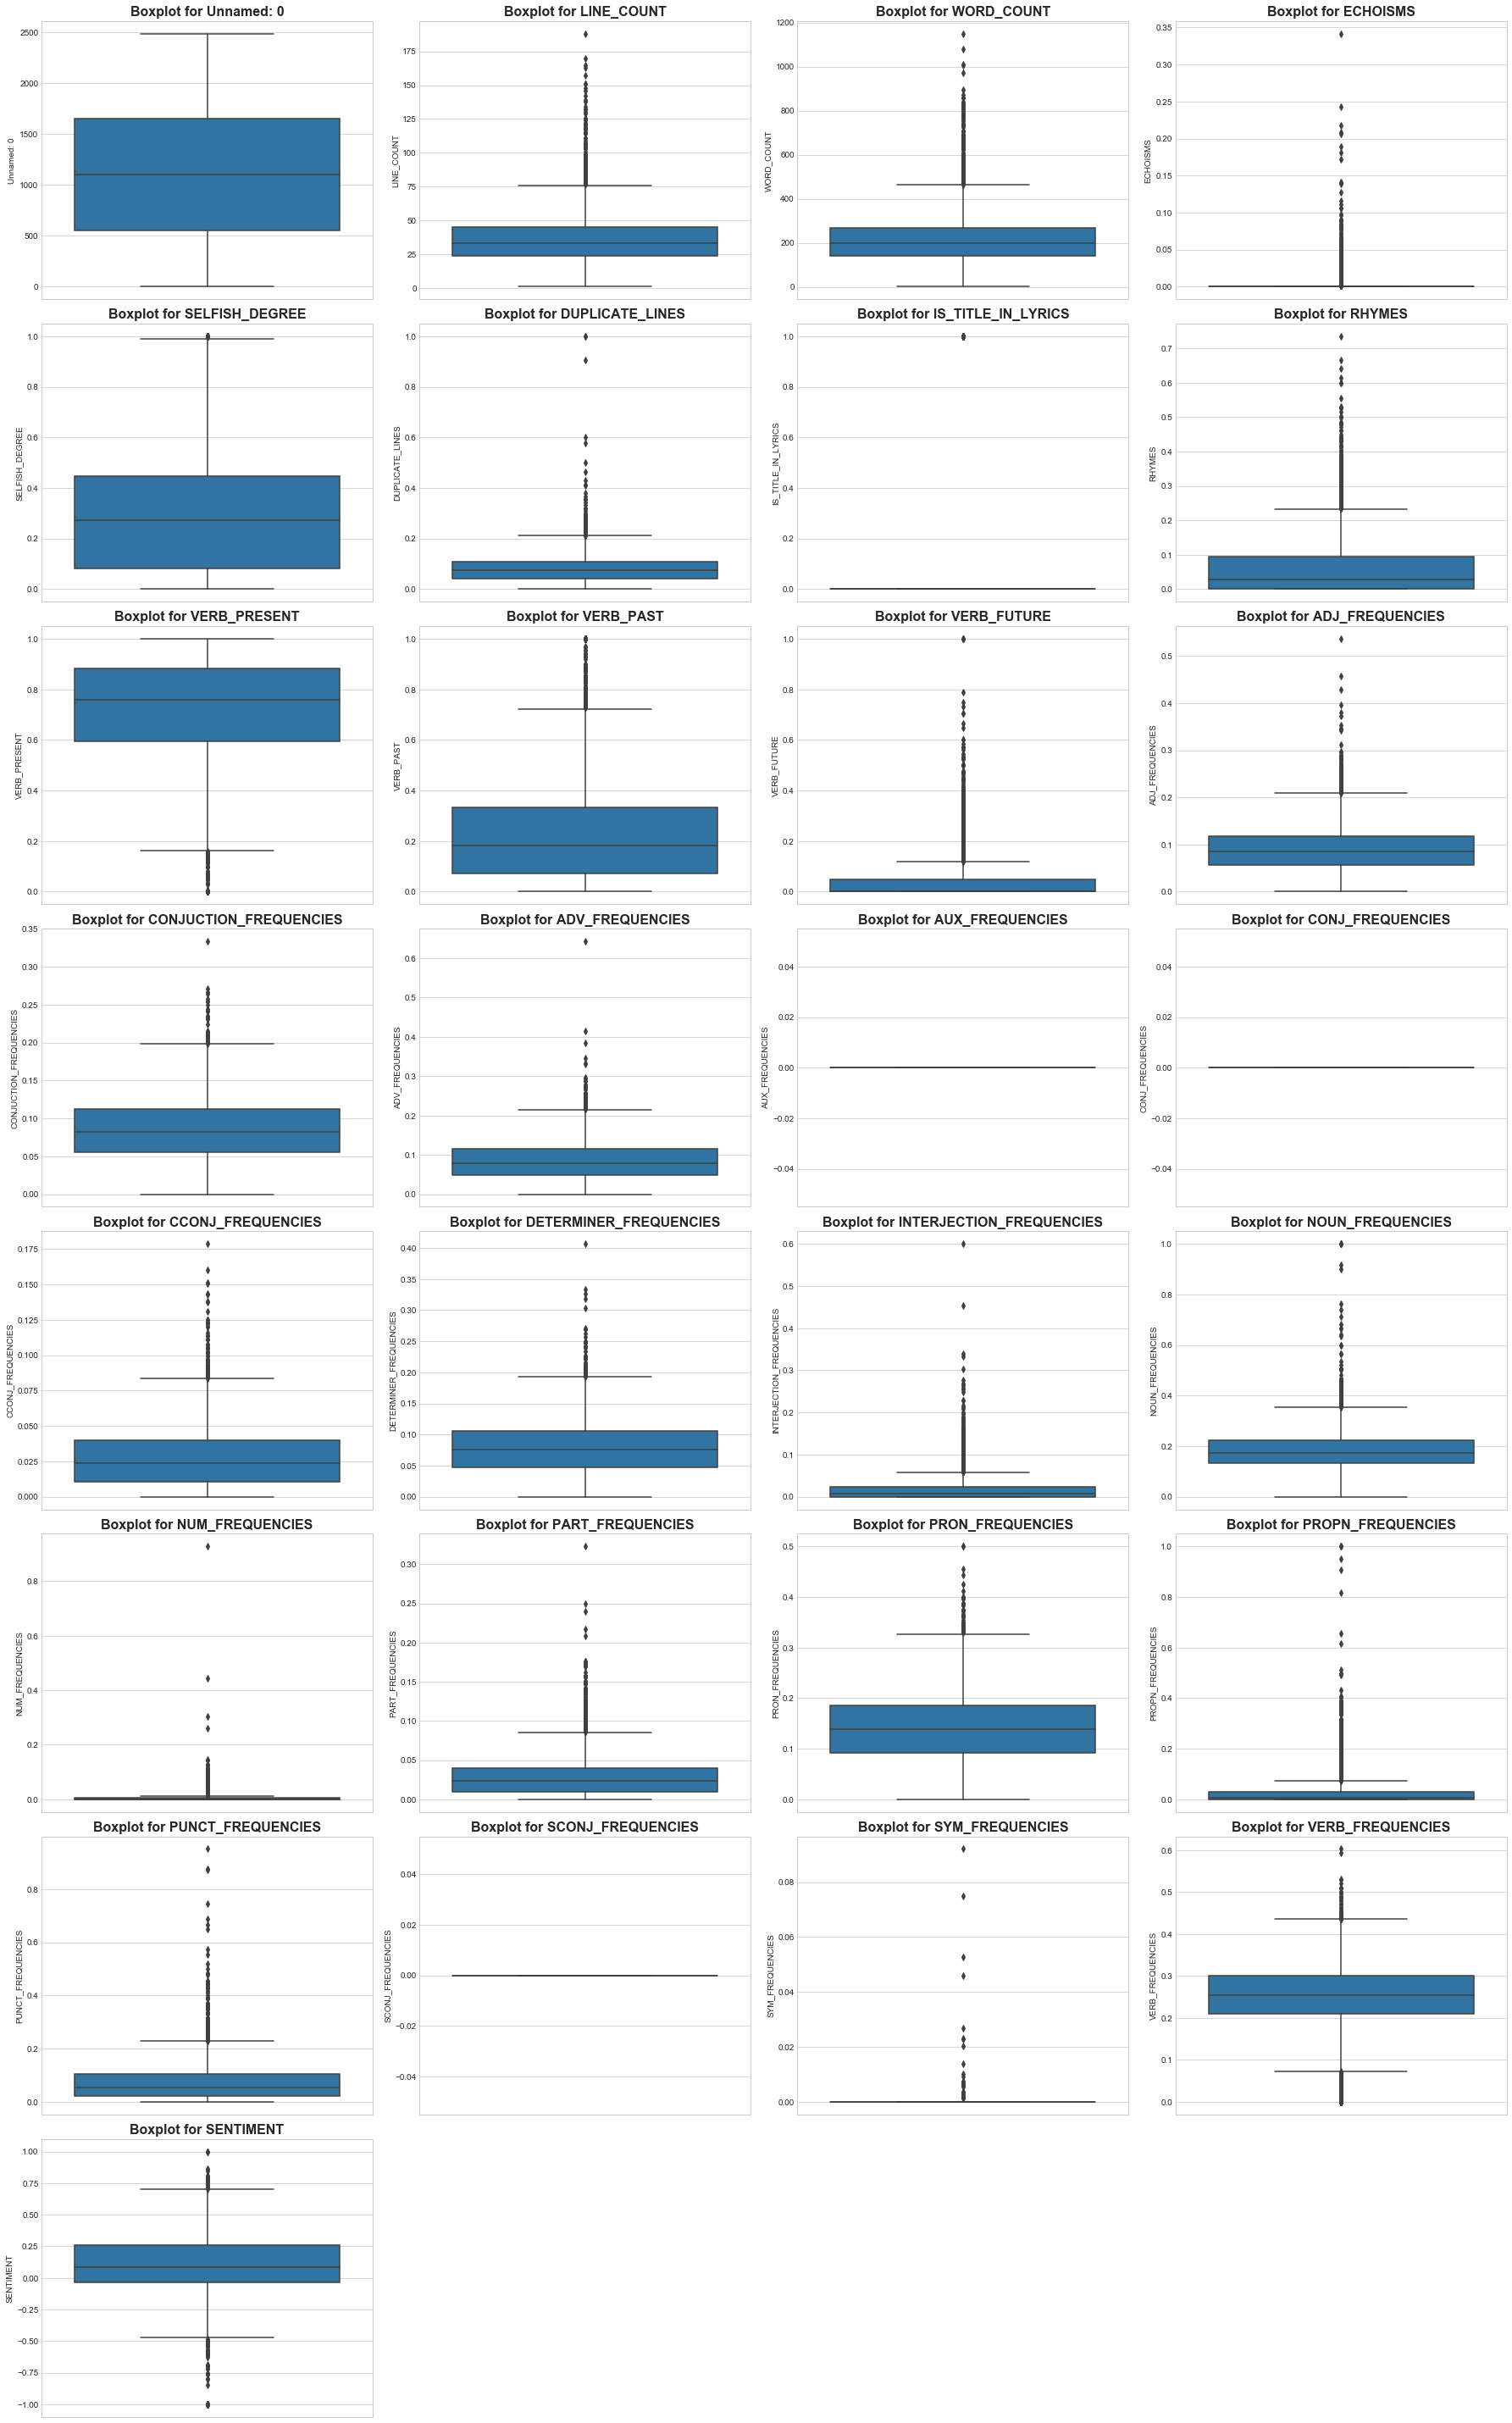

In [11]:
tmp_df = dataset.drop(useless_columns + ['LYRICS_VECTOR', 'TITLE_VECTOR'],axis=1)

f, axarr = plt.subplots(8, 4, figsize=(25,40))
k = 0
for feature in tmp_df.columns:
    (i, j) = divmod(k, 4)
    axarr[i,j] = sns.boxplot(y=tmp_df[feature], ax=axarr[i,j])
    axarr[i,j].set_title('Boxplot for {}'.format(feature), fontsize=16, weight='bold')
    k += 1
plt.tight_layout()
f.delaxes(axarr[-1,-1])
f.delaxes(axarr[-1,-2])
f.delaxes(axarr[-1,-3])

## Feature Selection

In [12]:
selected_columns = [
   'LYRICS_VECTOR',
   #'WORD_COUNT', 
   'ECHOISMS',
   #'SELFISH_DEGREE', 
   'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 
   'VERB_PRESENT', 
   'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES',
   'PUNCT_FREQUENCIES',
   'SENTIMENT', 'SUBJECTIVITY',
   'EMOTION'
]

In [13]:
# Reduced dataset and extra_test
r_dataset = dataset[selected_columns]
r_extra_test = extra_test[selected_columns]

In [16]:
tmp_df = r_dataset.drop(['EMOTION'], axis=1)
X = list()
for (i, row) in tmp_df.iterrows():
    sub_list = list()
    for field in row:
        if type(field) == str:
            field = field[1:-1].split()
            sub_list += [float(x.replace('\n','')) for x in field]
        else:
            sub_list.append(field)
    X.append(np.array(sub_list))
X = np.array(X)

In [19]:
y = r_dataset['EMOTION'].as_matrix().T

In [20]:
print(X.shape)
print(y.shape)

(4378, 310)
(4378,)


### Extra test set

In [21]:
tmp_df = r_extra_test.drop(['EMOTION'], axis=1)
X_test_extra = list()
for (i, row) in tmp_df.iterrows():
    sub_list = list()
    for field in row:
        if type(field) == str:
            field = field[1:-1].split()
            sub_list += [float(x.replace('\n','')) for x in field]
        else:
            sub_list.append(field)
    X_test_extra.append(np.array(sub_list))
X_test_extra = np.array(X_test_extra)

In [22]:
y_test_extra = extra_test['EMOTION'].as_matrix().T

In [23]:
print(X_test_extra.shape)
print(y_test_extra.shape)

(20, 310)
(20,)


# Classification

## Artificial Neural Network

In [24]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

encoder = LabelEncoder()

X_nn = X
encoded_y = encoder.fit_transform(y)
y_nn = np_utils.to_categorical(encoded_y)

sc = StandardScaler()
X_nn = sc.fit_transform(X_nn)

#print(np.shape(X_vect_nn), np.shape(y_nn))

X_train, X_test, y_train, y_test = train_test_split(X_nn, y_nn, test_size = 0.1, random_state = 13)
cm_labels = encoder.inverse_transform([0, 1, 2, 3])

/Users/saragiammusso/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [25]:
print(np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))

(3940, 310) (438, 310) (3940, 4) (438, 4)


In [27]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
    
from sklearn.utils import class_weight
    
def build_ann(optimizer='adam', input_size=X_nn.shape[1]):
    classifier = Sequential()
    
    # Add input layer
    classifier = Sequential()
    # Add input layer
    classifier.add(Dense(units = 175, kernel_initializer = 'random_normal', activation = 'sigmoid', input_dim = input_size))
    classifier.add(Dropout(0.1))
    
    # Add hidden layers
    classifier.add(Dense(units = 175, kernel_initializer = 'random_normal', activation = 'sigmoid'))
    classifier.add(Dropout(0.1))
                
    #classifier.add(Dense(units = 150, kernel_initializer = 'random_normal', activation = 'sigmoid'))
    #classifier.add(Dropout(0.5))
        
    # Add output layer
    classifier.add(Dense(units = 4, kernel_initializer = 'random_normal', activation = 'softmax'))
    
    # Compiling the ANN
    classifier.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return classifier

In [109]:
from keras.callbacks import EarlyStopping

classifier = build_ann('adam', X_train.shape[1])
early_stop = EarlyStopping(monitor='val_acc', min_delta=1e-3, patience=5, verbose=1, mode='auto')

classifier.fit(X_train, y_train, batch_size = 128, epochs = 100, 
               validation_split=0.1, verbose=False)

In [110]:
y_pred = classifier.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)

In [111]:
classifier.save('test.h5')

In [112]:
y_test_label = np.argmax(y_test,axis=1)
print(np.shape(y_test_label))
print(np.shape(y_pred))

(438,)
(438,)


Accuracy: 67.12


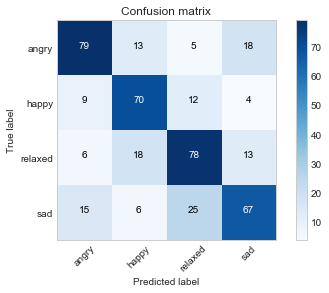

In [114]:
cm = confusion_matrix(y_test_label, y_pred)
plot_confusion_matrix(cm, classes=cm_labels)
plt.savefig('CM_ANN.png')
accuracy = (sum([cm[i,i] for i in range(len(cm))])) / len(y_pred)
print('Accuracy: %0.2f' % (accuracy*100))

### Cross Validation

In [46]:
from keras.wrappers.scikit_learn import KerasClassifier

keras_classifier = KerasClassifier(build_fn=build_ann)
parameters = {'batch_size': [128, 256],
              'epochs': [100,200],
              'optimizer': ['rmsprop', 'adam']}
grid_search = GridSearchCV(estimator = keras_classifier,
                           param_grid = parameters,
                           cv = 5)
grid_search = grid_search.fit(X_nn, y_nn, verbose=0)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_
best_classifier = grid_search.best_estimator_
print('Accuracy: %0.2f' % (best_accuracy*100))

3503/3503 [==============================] - 0s 24us/step
Accuracy: 68.98


In [47]:
best_parameters

{'batch_size': 256, 'epochs': 100, 'optimizer': 'rmsprop'}

### Analysis on Extra Test 

In [115]:
#print(np.shape(X_test_extra), np.shape(y_test_extra))
encoded_y_test_extra = encoder.transform(y_test_extra)
y_test_extra_nn = np_utils.to_categorical(encoded_y_test_extra)
y_test_extra_nn_label = np.argmax(y_test_extra_nn, axis=1)

In [116]:
y_pred_extra = classifier.predict(X_test_extra)
y_pred_extra = np.argmax(y_pred_extra, axis=1)

Accuracy: 35.00


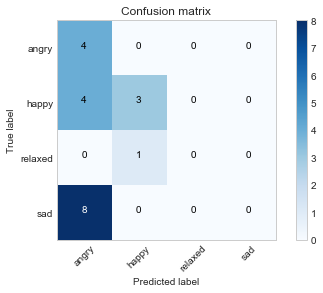

In [119]:
cm = confusion_matrix(y_test_extra_nn_label, y_pred_extra)
plot_confusion_matrix(cm, classes=cm_labels)
plt.savefig('CM_ANN_extra_test.png')
accuracy = (sum([cm[i,i] for i in range(len(cm))])) / len(y_test_extra_nn)
print('Accuracy: %0.2f' % (accuracy*100))

In [118]:
extra_test = pd.read_csv(extra_test_path)
for (idx, row) in extra_test.iterrows():
    print('Prediction for: "{}" from "{}"'.format(row['SONG_TITLE'], row['ARTIST']))
    print('\t - {}'.format(encoder.inverse_transform(y_pred_extra[idx])))

Prediction for: "Don't Worry, Be Happy" from "Bobby McFerrin"
	 - happy
Prediction for: "Don't Stop me Now" from "Queen"
	 - happy
Prediction for: "Happy" from "Pharrell Williams"
	 - happy
Prediction for: "I'm a believer" from "The Monkees"
	 - angry
Prediction for: "Toxic" from "Britney Spears"
	 - angry
Prediction for: "Buttons" from "The Pussycat Dolls"
	 - angry
Prediction for: "Crazy In Love" from "Beyoncé"
	 - angry
Prediction for: "Everybody Hurts" from "R.E.M."
	 - angry
Prediction for: "Someone Like You" from "Adele"
	 - angry
Prediction for: "Wish you were here" from "Pink Floyd"
	 - angry
Prediction for: "Hurt" from "Johnny Cash"
	 - angry
Prediction for: "Smells like teen spirit" from "Nirvana"
	 - angry
Prediction for: "My Boo" from "Usher"
	 - angry
Prediction for: "Rock Your Body" from "Justin Timberlake"
	 - angry
Prediction for: "It Wasn't Me" from "Shaggy"
	 - angry
Prediction for: "Killing in the name" from "Rage Against the Machine"
	 - angry
Prediction for: "Stron

/Users/saragiammusso/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/saragiammusso/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/saragiammusso/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/saragiammusso/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The tr

### Playlist Classification

In [136]:
import json

n_pl = 3

data = json.load(open('./datasets/spotify_slice_prova.json'))
pids = [12, 87, 94, 656, 821, 863, 612, 669, 728, 387, 578]
playlists = [p for p in data['playlists'] if p['pid'] in pids]
for playlist in playlists:
    print(playlist['pid'],playlist['name'])

12 relax
87 relax
94 relax
387 sad
578 sad
612 summer 17
656 feel good
669 summer 2k17
728 summer country
821 feel good
863 good vibes


In [596]:
from utils.dataset_parsing import *
import utils.sentiment_analysis as sa

In [597]:
def featurize(lyrics, pid, playlist_name, artist, title):
    lyric_doc = nlp(lyrics)
    title_doc = nlp(title)
    lyric = preprocess(lyrics)
    features = feature_extraction(lyric, title)

    freq = features['frequencies'] 
    sentiment = sa.analyse(lyrics)
    elem = [
        pid, playlist_name, 0, artist, title,
        lyric_doc.vector, title_doc.vector,
        features['line_count'], features['word_count'],#get_line_count(lyric), get_word_count(lyric),
        #get_slang_counts(lyric),
        features['echoisms'], features['selfish'],#get_echoisms(lyric), get_selfish_degree(lyric),
        count_duplicate_lines(lyric), features['is_title_in_lyrics'],# (row['Song'], lyric),
        features['rhymes'],#get_rhymes(lyric),
        features['verb_tenses']['present'], features['verb_tenses']['past'], features['verb_tenses']['future'], #verb_freq['present'], verb_freq['past'], verb_freq['future'],
        freq['ADJ'], freq['ADP'], freq['ADV'], freq['AUX'], freq['CONJ'], 
        freq['CCONJ'], freq['DET'], freq['INTJ'], freq['NOUN'], freq['NUM'],
        freq['PART'], freq['PRON'], freq['PROPN'], freq['PUNCT'], freq['SCONJ'],
        freq['SYM'], freq['VERB'], freq['X'], freq['SPACE'],
        # Sentiment analysis stuff
        sentiment[0], sentiment[1]
    ]
    return elem

In [598]:
import lyricwikia

In [599]:
features = list()
for playlist in playlists:
    for track in playlist['tracks']:
        artist = track['artist_name']
        title = track['track_name']
        try:
            lyrics = lyricwikia.get_lyrics(artist, title)
            x = featurize(lyrics, playlist['pid'], 'Test', artist, title)
            features.append(x)
        except lyricwikia.LyricsNotFound:
             continue
    df = pd.DataFrame(features, columns=['PlaylistPid','PlaylistName','TrackUri', 'ArtistName', 'TrackName','LYRICS_VECTOR', 'TITLE_VECTOR', 
            'LINE_COUNT', 'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
            'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'RHYMES', 'VERB_PRESENT', 
            'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES', 'CONJUCTION_FREQUENCIES', 
            'ADV_FREQUENCIES', 'AUX_FREQUENCIES', 'CONJ_FREQUENCIES', 'CCONJ_FREQUENCIES', 
            'DETERMINER_FREQUENCIES', 'INTERJECTION_FREQUENCIES', 'NOUN_FREQUENCIES', 
            'NUM_FREQUENCIES', 'PART_FREQUENCIES', 'PRON_FREQUENCIES', 'PROPN_FREQUENCIES', 
            'PUNCT_FREQUENCIES', 'SCONJ_FREQUENCIES', 'SYM_FREQUENCIES', 'VERB_FREQUENCIES',
            'X_FREQUENCIES', 'SPACE_FREQUENCIES', 
            'SENTIMENT', 'SUBJECTIVITY'])
df.head(3)

,PlaylistPid,PlaylistName,TrackUri,ArtistName,TrackName,LYRICS_VECTOR,TITLE_VECTOR,LINE_COUNT,WORD_COUNT,ECHOISMS,...,PRON_FREQUENCIES,PROPN_FREQUENCIES,PUNCT_FREQUENCIES,SCONJ_FREQUENCIES,SYM_FREQUENCIES,VERB_FREQUENCIES,X_FREQUENCIES,SPACE_FREQUENCIES,SENTIMENT,SUBJECTIVITY
0,612,Test,0,blackbear,do re mi,"[-0.060807034, 0.10102596, -0.24047479, -0.076...","[0.15788434, -0.04598233, -0.22609265, -0.2653...",51,374,0.0,...,0.133690,0.021390,0.008021,0.0,0.0,0.243316,0.048128,0.0,-0.227652,0.580808
1,612,Test,0,Post Malone,Go Flex,"[-0.0051151467, 0.17242686, -0.18923114, -0.02...","[0.14533, 0.100967005, 0.20689498, 0.288135, 0...",31,266,0.0,...,0.131579,0.000000,0.067669,0.0,0.0,0.244361,0.000000,0.0,-0.271364,0.625455
2,612,Test,0,Drake,Madiba Riddim,"[-0.021780357, 0.17223118, -0.23054837, -0.082...","[0.008369, 0.0218645, 0.25986, -0.48902, 0.218...",45,292,0.0,...,0.215753,0.044521,0.061644,0.0,0.0,0.332192,0.000000,0.0,0.315760,0.450113


In [600]:
tmp_df = df[[
   'LYRICS_VECTOR',
   'ECHOISMS', 
   'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'VERB_PRESENT', 
   'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES',
   'PUNCT_FREQUENCIES',
   'SENTIMENT', 'SUBJECTIVITY']]#.drop(['PlaylistPid', 'PlaylistName', 'TrackUri', 'ArtistName', 'TrackName'], axis=1, inplace=True)
X_vect = list()
for (i, row) in tmp_df.iterrows():
    sub_list = list()
    for field in row:
        if type(field) == np.ndarray:
            sub_list += [float(x) for x in field]
        else:
            sub_list.append(field)
    X_vect.append(np.array(sub_list))
X_vect = np.array(X_vect)
X_vect.shape

(57, 310)

In [601]:
X_vect_nn = sc.transform(X_vect)

In [602]:
y_pred = classifier.predict(X_vect_nn, verbose=0)

In [603]:
classificationDf = pd.DataFrame(data=y_pred,columns=cm_labels)
finalDf = pd.concat([df, classificationDf],axis=1)

In [604]:
finalDf[cm_labels].head(5)

,angry,happy,relaxed,sad
0,0.090471,0.004921,0.902696,0.001912
1,0.991460,0.002359,0.000440,0.005741
2,0.109958,0.051137,0.817349,0.021557
3,0.366557,0.118908,0.049511,0.465023
4,0.794785,0.145631,0.055512,0.004072


In [605]:
map_mean = dict()
for emo in cm_labels:
    map_mean[emo] = 'mean'
playlistDf = finalDf.groupby(by='PlaylistPid').agg(map_mean)

In [606]:
playlistDf.head(n_pl)

,angry,relaxed,happy,sad
PlaylistPid,,,,
612,0.371769,0.174252,0.382049,0.07193


## Logistic Regression

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 13)

In [29]:
from sklearn.linear_model import LogisticRegression
def evaluate_logreg(X_train, y_train, X_test, y_test):
    classifier = LogisticRegression(penalty='l2', dual=False, C=25,
                                    solver='newton-cg', multi_class='multinomial', random_state=0)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=cm_labels)
    plt.savefig('CM_LR'+str(len(y_test))+'.png')
    print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.68


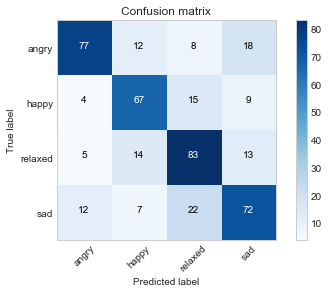

In [30]:
evaluate_logreg(X_train, y_train, X_test, y_test)

Accuracy of logistic regression classifier on test set: 0.45


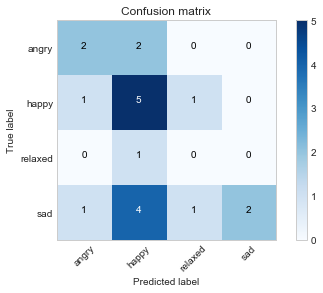

In [31]:
evaluate_logreg(X_train, y_train, X_test_extra, y_test_extra)

### Playlist Classification

In [ ]:
clf = LogisticRegression(penalty='l2', dual=False, C=0.15, 
                         solver='newton-cg', multi_class='multinomial', random_state=0)
clf.fit(X_train, y_train)

In [ ]:
import json

n_pl = 5

data = json.load(open('./datasets/mpd.slice.0-999.json'))
playlists = data['playlists'][:n_pl]

In [ ]:
from utils.dataset_parsing import *
import utils.sentiment_analysis as sa

In [ ]:
def featurize(lyrics, pid, playlist_name, artist, title):
    lyric_doc = nlp(lyrics)
    title_doc = nlp(title)
    lyric = preprocess(lyrics)
    features = feature_extraction(lyric, title)

    freq = features['frequencies'] 
    sentiment = sa.analyse(lyrics)
    elem = [
        pid, playlist_name, 0, artist, title,
        lyric_doc.vector, title_doc.vector,
        features['line_count'], features['word_count'],#get_line_count(lyric), get_word_count(lyric),
        #get_slang_counts(lyric),
        features['echoisms'], features['selfish'],#get_echoisms(lyric), get_selfish_degree(lyric),
        count_duplicate_lines(lyric), features['is_title_in_lyrics'],# (row['Song'], lyric),
        features['rhymes'],#get_rhymes(lyric),
        features['verb_tenses']['present'], features['verb_tenses']['past'], features['verb_tenses']['future'], #verb_freq['present'], verb_freq['past'], verb_freq['future'],
        freq['ADJ'], freq['ADP'], freq['ADV'], freq['AUX'], freq['CONJ'], 
        freq['CCONJ'], freq['DET'], freq['INTJ'], freq['NOUN'], freq['NUM'],
        freq['PART'], freq['PRON'], freq['PROPN'], freq['PUNCT'], freq['SCONJ'],
        freq['SYM'], freq['VERB'], freq['X'], freq['SPACE'],
        # Sentiment analysis stuff
        sentiment[0], sentiment[1]
    ]
    return elem

In [ ]:
import lyricwikia

In [ ]:
features = list()
for playlist in playlists:
    for track in playlist['tracks']:
        artist = track['artist_name']
        title = track['track_name']
        try:
            lyrics = lyricwikia.get_lyrics(artist, title)
            x = featurize(lyrics, playlist['pid'], 'Test', artist, title)
            features.append(x)
        except lyricwikia.LyricsNotFound:
             continue
    df = pd.DataFrame(features, columns=['PlaylistPid','PlaylistName','TrackUri', 'ArtistName', 'TrackName','LYRICS_VECTOR', 'TITLE_VECTOR', 
            'LINE_COUNT', 'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
            'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'RHYMES', 'VERB_PRESENT', 
            'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES', 'CONJUCTION_FREQUENCIES', 
            'ADV_FREQUENCIES', 'AUX_FREQUENCIES', 'CONJ_FREQUENCIES', 'CCONJ_FREQUENCIES', 
            'DETERMINER_FREQUENCIES', 'INTERJECTION_FREQUENCIES', 'NOUN_FREQUENCIES', 
            'NUM_FREQUENCIES', 'PART_FREQUENCIES', 'PRON_FREQUENCIES', 'PROPN_FREQUENCIES', 
            'PUNCT_FREQUENCIES', 'SCONJ_FREQUENCIES', 'SYM_FREQUENCIES', 'VERB_FREQUENCIES',
            'X_FREQUENCIES', 'SPACE_FREQUENCIES', 
            'SENTIMENT', 'SUBJECTIVITY'])
df.head(3)

In [ ]:
tmp_df = df[[
   'LYRICS_VECTOR',
   'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
   'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'VERB_PRESENT', 
   'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES',
   'PUNCT_FREQUENCIES',
   'SENTIMENT', 'SUBJECTIVITY']]#.drop(['PlaylistPid', 'PlaylistName', 'TrackUri', 'ArtistName', 'TrackName'], axis=1, inplace=True)
X_vect = list()
for (i, row) in tmp_df.iterrows():
    sub_list = list()
    for field in row:
        if type(field) == np.ndarray:
            sub_list += [float(x) for x in field]
        else:
            sub_list.append(field)
    X_vect.append(np.array(sub_list))
X_vect = np.array(X_vect)
X_vect.shape

In [ ]:
y_pred = clf.predict_proba(X_vect)

In [ ]:
classificationDf = pd.DataFrame(data=y_pred,columns=cm_labels)
finalDf = pd.concat([df, classificationDf],axis=1)

In [ ]:
finalDf[['angry', 'happy', 'relaxed', 'sad']].head(5)

In [ ]:
playlistDf = finalDf.groupby(by='PlaylistPid').agg({'happy': 'mean', 'sad': 'mean', 'angry': 'mean', 'relaxed': 'mean'})

In [ ]:
playlistDf.head(n_pl)

## SVM 

In [32]:
def parameters_grid_search(classifier, params, x, y, cv=10, verbose=False):
    """
    Grid Search to find best parameters for a certain classifier whose
    performances are evaluated using cross-validation
    """
    gs = GridSearchCV(classifier(), params, cv=cv, n_jobs=-1, verbose=verbose)
    gs.fit(x, y)    
    return (gs.best_estimator_, gs.best_params_)

In [33]:
from sklearn.svm import SVC

In [34]:
clf = SVC(C=220, kernel='rbf')
clf.fit(X_train, y_train)

SVC(C=220, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Accuracy of SVM classifier on test set: 69.178 %


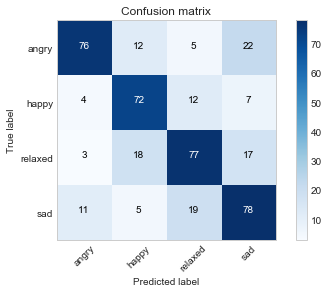

In [35]:
y_pred = clf.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=cm_labels)
plt.savefig('CM_SVM')
print('Accuracy of SVM classifier on test set: {:.3f} %'.format(clf.score(X_test, y_test) * 100))

Accuracy of SVM classifier on extra test set: 0.55


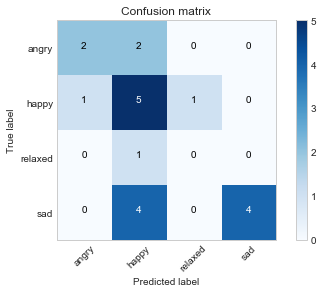

In [36]:
y_pred_extra = clf.predict(X_test_extra)
plot_confusion_matrix(confusion_matrix(y_test_extra, y_pred_extra), classes=cm_labels)
plt.savefig('CM_SVM_extra_test')
print('Accuracy of SVM classifier on extra test set: {:.2f}'.format(clf.score(X_test_extra, y_test_extra)))

## eXtreme Gradient Boost

In [37]:
import xgboost

ModuleNotFoundError: No module named 'xgboost'

In [211]:
xgb = xgboost.XGBClassifier()
xgb.fit(X_train_pca, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [212]:
predictions = xgb.predict(X_test_pca)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 54.12%


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [ ]:
features = list()
for playlist in playlists:
    for track in playlist['tracks']:
        artist = track['artist_name']
        title = track['track_name']
        try:
            lyrics = lyricwikia.get_lyrics(artist, title)
            x = featurize(lyrics, playlist['pid'], 'Test', artist, title)
            features.append(x)
        except lyricwikia.LyricsNotFound:
             continue
    df = pd.DataFrame(features, columns=['PlaylistPid','PlaylistName','TrackUri', 'ArtistName', 'TrackName','LYRICS_VECTOR', 'TITLE_VECTOR', 
            'LINE_COUNT', 'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
            'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'RHYMES', 'VERB_PRESENT', 
            'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES', 'CONJUCTION_FREQUENCIES', 
            'ADV_FREQUENCIES', 'AUX_FREQUENCIES', 'CONJ_FREQUENCIES', 'CCONJ_FREQUENCIES', 
            'DETERMINER_FREQUENCIES', 'INTERJECTION_FREQUENCIES', 'NOUN_FREQUENCIES', 
            'NUM_FREQUENCIES', 'PART_FREQUENCIES', 'PRON_FREQUENCIES', 'PROPN_FREQUENCIES', 
            'PUNCT_FREQUENCIES', 'SCONJ_FREQUENCIES', 'SYM_FREQUENCIES', 'VERB_FREQUENCIES',
            'X_FREQUENCIES', 'SPACE_FREQUENCIES', 
            'SENTIMENT', 'SUBJECTIVITY'])
df.head(3)

# Conclusion
